In [1]:
import pandas as pd
from os import listdir
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#create a dataFrame from each file
mortgage_rates=pd.read_csv("MORTGAGE30US.csv",index_col=0)
mortgage_rates.index=pd.to_datetime(mortgage_rates.index)
US_median_price=pd.read_csv("US_median_home_price.csv",index_col=0)
US_median_price.index=pd.to_datetime(US_median_price.index)

#csv file has 5 columns. we only need the Open price
SP500_df=pd.read_csv('HistoricalPrices.csv',index_col=0,usecols=[0,1])
SP500_df.index=pd.to_datetime(SP500_df.index)
#sort chronologically, every business day is included
SP500_df.sort_index(inplace=True) 

We will use the S&P500 index to represent the US stock market overall. Many mutual funds and exchange-traded funds track this index and are readily available for any person to buy shares. For example, anyone can buy shares of Schwab S&P 500 Index Fund (SWPPX) or Vanguard S&P 500 ETF (VOO) (or other examples) and effectively be invested in all 500 of the most successful US companies. There is also an index for the total stock market, the Dow Jones US total market index, and it turns out that this index is extremely correlated with the S&P500 index, so our results will generalize to investment strategies based on the Dow Jones total market index.

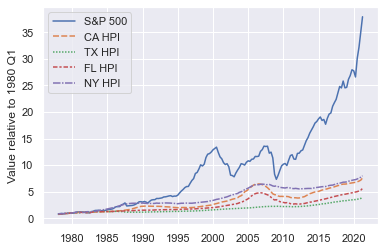

In [2]:
#take average of each quarter to compare with the housing price index
SP500_q=SP500_df.resample('QS').mean()
#normalize to 1980 Q1, same as house price index
SP500_q=SP500_q/SP500_q[SP500_q.index==datetime(1980,1,1)].values

#load the csv files of the states
files=listdir("states/")
frames=[]
for f in files:
    #load the csv into a DataFrame
    frames.append(pd.read_csv('states/'+f,index_col=0))
#combine all frames into a single frame. 1980 Q1 is set to 1
states_HPI=frames[0].join(frames[1:])/100
#dates are the first day of each quarter
states_HPI.index=pd.to_datetime(states_HPI.index)

#create a new frame with all data as columns
df=SP500_q.join(states_HPI,how='inner')
df.rename(columns={' Open': 'S&P 500',
                   'NYSTHPI': 'NY HPI',
                  'TXSTHPI': 'TX HPI',
                  'CASTHPI': 'CA HPI',
                  'FLSTHPI': 'FL HPI'},inplace=True)
sns.set()
#let's look at the 4 largest states in population
sns.lineplot(data=df[['S&P 500','CA HPI','TX HPI','FL HPI','NY HPI']])
plt.ylabel('Value relative to 1980 Q1')
plt.show()

Compared to the house price indices, the stock market index, S&P 500, has experienced the greatest growth and also the largest downturns such as the early 2000s and 2008-2009. These events mean that the index fund has greater risk depending on how long you leave money in the fund. Generally, the house prices for California, Texas, Florida, and New York have tended to increase over the last 40 years, but their growth is quite small compared to the S&P 500. California, Florida, and New York house prices dipped in 2008 just like the stock market. However, the California real estate market took about 8 years to recover to the pre-crash peak, much longer compared to the rebound in the stock market.

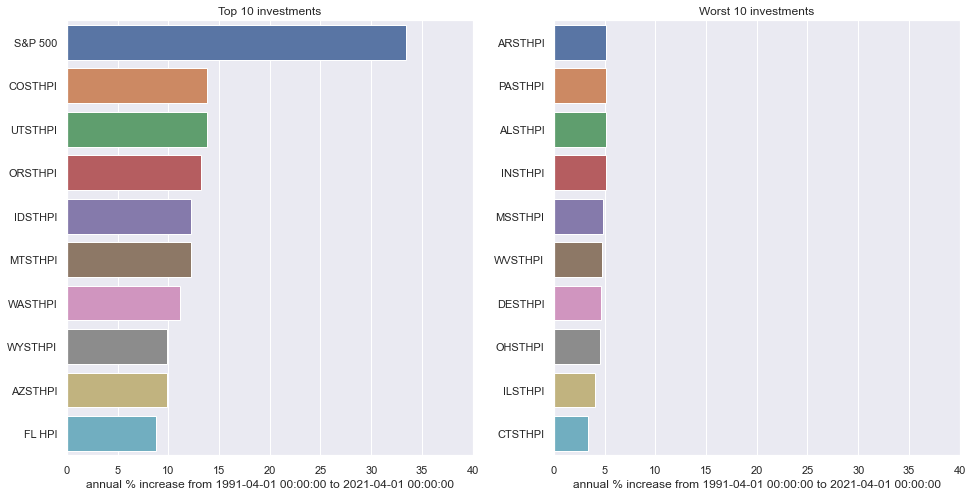

In [3]:

def calc_changes(df,start_date,final_date):
    """ Calculate the % change of each of the categories in a DataFrame
    INPUTS
    df: pandas dataframe with a datetime index
    start_time: datetime object
    final_date: datetime object
    OUTPUT
    changes: values are the yearly average
    """
    ind=df.index>=start_date
    #select the closest values to the start date
    start_val=df[ind].iloc[0]
    stop_val=df[df.index>=final_date].iloc[0]
    #how much would the investment grow in each column?
    changes=(stop_val-start_val)/start_val
    n_years=final_date.year-start_date.year +(final_date.month-start_date.month)/12
    #convert DataFrame to a Series and change to percentage
    changes=changes.squeeze(axis=0)*100/n_years 
    changes.sort_values(inplace=True,ascending=False)
    return changes

#choose a start date
start_date=datetime(1991,4,1)
#choose the last date that's available
final_date=df.index[-1]
example1=calc_changes(df,start_date,final_date)
#show these changes in a bar plot
def plot_best_and_worst(for_plot,start_date,final_date,use_xlim=False):
    fig, ax=plt.subplots(1,2,figsize=(16,8))
    for_xaxis='annual % increase from '+str(start_date)+' to '+str(final_date)
    sns.barplot(x=for_plot,y=for_plot.index,ax=ax[0],orient='h')
    ax[0].set_title('Top 10 investments')
    ax[0].set_xlabel(for_xaxis)
    if use_xlim:
        ax[0].set_xlim(0,40)
    for_plot=example1[-10:]
    sns.barplot(x=for_plot,y=for_plot.index,ax=ax[1],orient='h')
    ax[1].set_title('Worst 10 investments')
    ax[1].set_xlabel(for_xaxis)
    if use_xlim:
        ax[1].set_xlim(0,40)
    plt.show()
#only plot the top 10
plot_best_and_worst(example1[0:10],start_date,final_date,True)

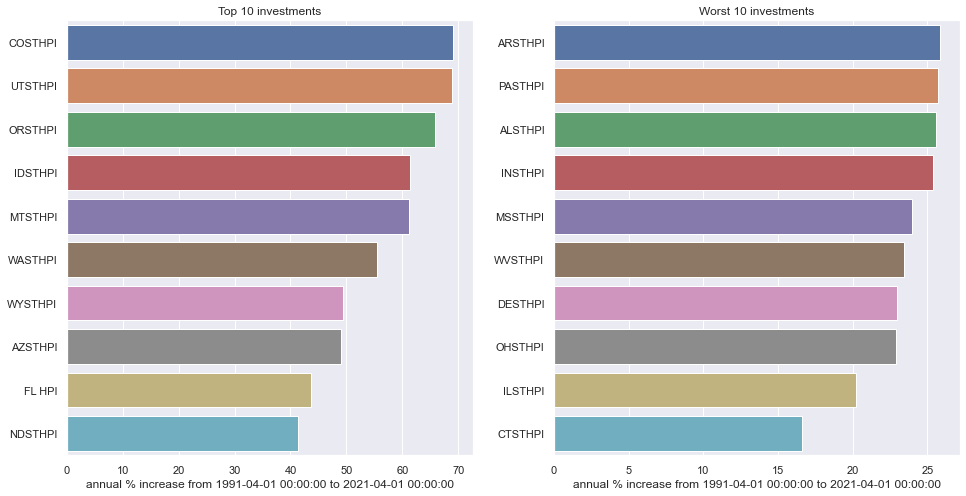

In [4]:
example1=calc_changes(df,start_date,final_date)
#determine the average interest rate on a fixed, 30-year loan at the purchase time
int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
example1[1:]=example1[1:]*5-int_rate[0]/100
example1.sort_values(inplace=True,ascending=False)
plot_best_and_worst(example1[0:10],start_date,final_date)

Now we have adjusted the real estate gains relative to the downpayment, instead of the house value, and we have subtracted the mortgage rate. The S&P 500 falls below the top 10, but not all the way to the worst 10. However, you may argue that this comparison is unfair because the scenarios with a home purchase all assume the full repayment of the mortgage, whereas the nest egg in the index fund grew without any additional payments and without dividends reinvested.

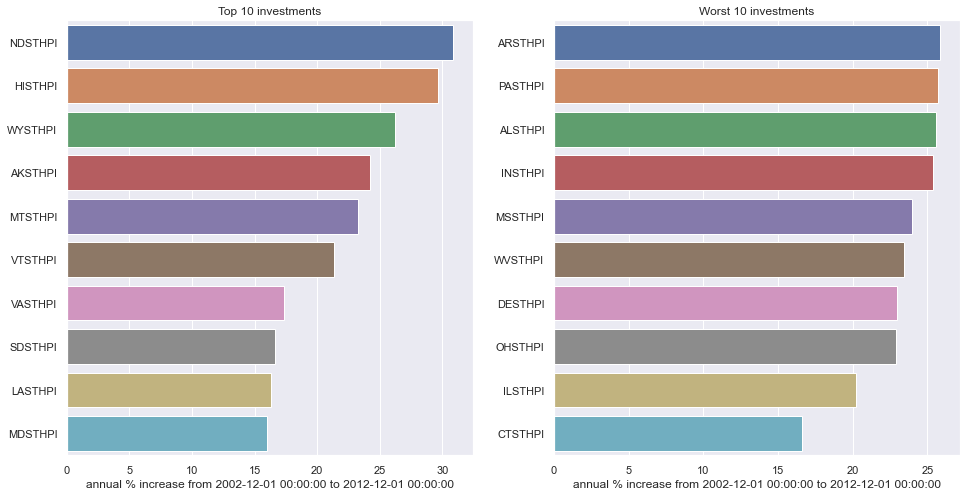

In [5]:
final_date=datetime(2012,12,1)
start_date=datetime(2002,12,1)
example2=calc_changes(df,start_date,final_date)
example2[1:]=example2[1:]*5-int_rate[0]/100
example2.sort_values(inplace=True,ascending=False)
plot_best_and_worst(example2[0:10],start_date,final_date)

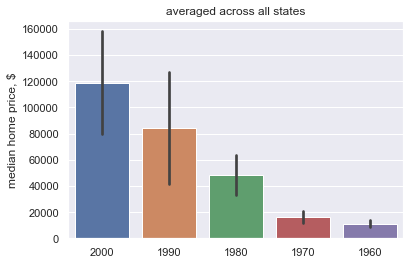

In [6]:
median_home=pd.read_csv("https://www2.census.gov/programs-surveys/decennial/tables/time-series/coh-values/values-unadj.txt",
                        header=None,skiprows=4,skipfooter=3,engine='python',sep='$',usecols=range(6))
median_home.columns=['state','2000','1990','1980','1970','1960']
for col in median_home.columns[1:]:
    #remove commas and convert to numbers
    median_home[col]=pd.to_numeric(median_home[col].str.replace(",",""))
#first row is for United states and we will drop it during the merge
median_home['for_merge']=np.arange(len(median_home))-1
#add columns of abbreviations and state names that don't have space fillers
frame=pd.read_csv('state_abbrev.csv')
median_home=pd.merge(frame,median_home,left_index=True,right_on='for_merge')
median_home.drop(['state','for_merge'],axis='columns',inplace=True)
#median_home.describe()

sns.barplot(data=median_home, ci="sd")
plt.ylabel('median home price, $')
plt.title('averaged across all states')
plt.show()

In [7]:
median_home['1990'].describe()

count        51.000000
mean      84209.803922
std       42980.983027
min       45200.000000
25%       57400.000000
50%       68900.000000
75%       94950.000000
max      245300.000000
Name: 1990, dtype: float64

In [8]:
#initial investment
principal=10000 #$10k

def calc_mortgage(mortgage_rates,start_date,downpayment,final_date):
    """ Calculates the total cost of a mortgage
    Assumes that the mortage is for 30 years at a fixed interest rate.
    INPUT
    mortgage_rates: DataFrame of interest rates which are not fractional, but are percentages multiplied by 100
    start_date: datetime object
    downpayment: downpayment for home purchase
    """
    #determine the average interest rate on a fixed, 30-year loan at the purchase time
    int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
    r=int_rate[0]/12/100 #monthly interest rate
    N_total=30*12 # number of monthly payments
    #assume the principal investment is 20% of the home price
    house_price=5*downpayment
    #calculate the initial value of the loan
    loan_principal=house_price-downpayment
    #calculate the monthly mortgage payment
    cost=loan_principal*r/(1-(1 + r)**(-N_total))
    #how many months have passed?
    N_elapsed=(final_date.year-start_date.year)*12 + final_date.month-start_date.month
    #calculate the total cost of the mortgage
    cost=cost*np.array([N_total, N_elapsed])
    return cost, house_price

cost, house_price=calc_mortgage(mortgage_rates,start_date,principal,final_date)

